# The Product Pricer with Frontier Models - Fine Tuning

In [1]:
## imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
from testing import Tester
%matplotlib inline

In [2]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')

In [3]:
openai = OpenAI()

In [4]:
## Load the pickle files
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
len(train)

25000

In [6]:
len(test)

2000

In [8]:
## OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our prompts are very small, we go with 500 examples (and 1 epoch)
fine_tune_train = train[:250]
fine_tune_validation = train[250:300]

# Step 1

Prepare data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [9]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [11]:
## Convert the items into jsonl and write them to a file
def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [12]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [13]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

#### Load training and validation JSONL files to the open AI

In [14]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [18]:
train_file

FileObject(id='file-VujYYc3k5V9rnfpf1eft3p', bytes=242227, created_at=1757490595, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [16]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-S33UCGvkGegiQYEUjXVG58', bytes=47425, created_at=1757490598, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# Step 2

To see how training happened inside OpenAI, we can use weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, add Weights & Biases key.

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "thilina-gpt-40-min-tuned"}}

#### Fine-tune the gpt-40-mini model

In [21]:
openai.fine_tuning.jobs.create(
    training_file = train_file.id,
    validation_file = validation_file.id,
    model = "gpt-4.1-2025-04-14",
    seed = 42,
    hyperparameters = {"n_epochs": 1},
    integrations = [wandb_integration],
    suffix = "thilina-pricer-model"
)

FineTuningJob(id='ftjob-GfgvMazOwGux4k8SGDZ1wIZT', created_at=1757490673, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-2rUwirWRA9xxKuWv2pbCQozo', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-VujYYc3k5V9rnfpf1eft3p', validation_file='file-S33UCGvkGegiQYEUjXVG58', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='thilina-gpt-40-min-tuned', entity=None, name=None, tags=None, run_id='ftjob-GfgvMazOwGux4k8SGDZ1wIZT'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suf

In [22]:
openai.fine_tuning.jobs.list(limit=5) ### by using this line, we can see the latest jobs

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-GfgvMazOwGux4k8SGDZ1wIZT', created_at=1757490673, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-2rUwirWRA9xxKuWv2pbCQozo', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-VujYYc3k5V9rnfpf1eft3p', validation_file='file-S33UCGvkGegiQYEUjXVG58', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='thilina-gpt-40-min-tuned', entity=None, name=None, tags=None, run_id='ftjob-GfgvMazOwGux4k8SGDZ1wIZT'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='aut

In [23]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [24]:
job_id

'ftjob-GfgvMazOwGux4k8SGDZ1wIZT'

In [25]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-GfgvMazOwGux4k8SGDZ1wIZT', created_at=1757490673, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-2rUwirWRA9xxKuWv2pbCQozo', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-VujYYc3k5V9rnfpf1eft3p', validation_file='file-S33UCGvkGegiQYEUjXVG58', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='thilina-gpt-40-min-tuned', entity=None, name=None, tags=None, run_id='ftjob-GfgvMazOwGux4k8SGDZ1wIZT'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suf

In [62]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-xO1cDuzWZl1XaaIDPnPOpgn8', created_at=1757492795, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-HQpyTdhWklvL0UcANKakpOsX', created_at=1757492788, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-fodAqz4mmx9fLKUhdIY9F8SL', created_at=1757492788, level='info', message='Moderation checks for snapshot ft:gpt-4.1-2025-04-14:personal:thilina-pricer-model:CEAFTFNe passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement': 

# Step 3

Test the fine tuned model

In [63]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [64]:
fine_tuned_model_name

'ft:gpt-4.1-2025-04-14:personal:thilina-pricer-model:CEAFTFNe'

In [65]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [66]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [67]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [68]:
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model = fine_tuned_model_name, 
        messages = messages_for(item),
        seed = 42,
        max_tokens = 7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [69]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

65.99
39.99


1: Guess: $39.99 Truth: $65.99 Error: $26.00 SLE: 0.24 Item: Setpower Insulated Protective Cover for ...
2: Guess: $7.98 Truth: $9.68 Error: $1.70 SLE: 0.03 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $99.99 Truth: $155.98 Error: $55.99 SLE: 0.19 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $5.99 Truth: $5.59 Error: $0.40 SLE: 0.00 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $128.66 Truth: $98.40 Error: $30.26 SLE: 0.07 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $59.99 Truth: $54.99 Error: $5.00 SLE: 0.01 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $10.99 Truth: $5.71 Error: $5.28 SLE: 0.34 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $10.99 Truth: $9.53 Error: $1.46 SLE: 0.02 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $15.99 Truth: $11.24 Error: $4.75 SLE: 0.11 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $10.99 Truth: $12.88 Error: $1.89 SLE: 0.02 Item: Away NV350 NV351

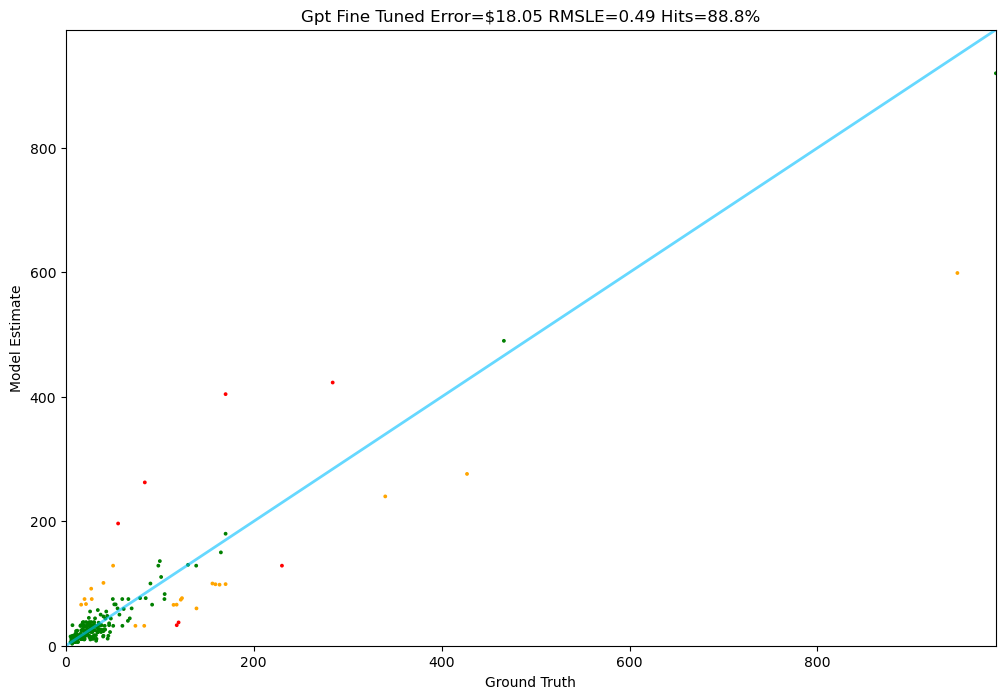

In [70]:
Tester.test(gpt_fine_tuned, test)